## Load in Packages

In [1]:
suppressPackageStartupMessages({ 
    library(data.table) 
    library(dplyr) 
    library(ggplot2) 
    library(SingleCellExperiment)
    library(dplyr)
    library(celldex)
    library(SingleR)
    library(RColorBrewer)
    library(scater) 
    library(StabMap) 
    library(scran) 
    library(harmony) 
    library(patchwork)
    library(Seurat)
    library(plotly)
    library(Matrix)
    library(stringr)
    library(cowplot)
})

## Set Data Locations and Load in the Datasets

In [2]:
# set paths to data locations
io = list()
io$main = "/rds/project/rds-SDzz0CATGms/users/ltgh2/"
# set the working directory
setwd(io$main)

# set paths to data locations for the query samples
io$integrated_object = file.path(io$main, "projects/10_Axin_1_2/outputs/axin_object_integrated_e6_8_Original_Atlas.rds")

# load in the query data 
integrated_object <- readRDS(io$integrated_object)

In [3]:
# set paths to data locations for the query samples
io$query = file.path(io$main, "projects/10_Axin_1_2/outputs/deprec/integrated_axin_dataset_seurat.rds")

# load in the query data 
query <- readRDS(io$query)

In [4]:
# Load in the new MetaData from the Mapping
# set paths to data locations for the query samples
io$axin_transferred_anatomy = file.path(io$main, "projects/10_Axin_1_2/outputs/axin_transferred_anatomy.rds")
axin_transferred_anatomy <- readRDS(io$axin_transferred_anatomy)

io$axin_transferred_celltype_extended_atlas = file.path(io$main, "projects/10_Axin_1_2/outputs/axin_transferred_celltype_extended_atlas.rds")
axin_transferred_celltype_extended_atlas <- readRDS(io$axin_transferred_celltype_extended_atlas)

io$axin_transferred_celltype_PijuanSala2019 = file.path(io$main, "projects/10_Axin_1_2/outputs/axin_transferred_celltype_PijuanSala2019.rds")
axin_transferred_celltype_PijuanSala2019 <- readRDS(io$axin_transferred_celltype_PijuanSala2019)

io$axin_transferred_stage = file.path(io$main, "projects/10_Axin_1_2/outputs/axin_transferred_stage.rds")
axin_transferred_stage <- readRDS(io$axin_transferred_stage)

io$integrated_object_clusters = file.path(io$main, "projects/10_Axin_1_2/outputs/integrated_object_clusters.rds")
integrated_object_clusters <- readRDS(io$integrated_object_clusters)

In [5]:
# subset the predicted labels and the mapping score
axin_extended_celltype <- subset(axin_transferred_celltype_extended_atlas, select = c(predicted.id, prediction.score.max))
colnames(axin_extended_celltype) <- c("extended_celltype", "extended_celltype_mappingscore")          

axin_original_celltype <- subset(axin_transferred_celltype_PijuanSala2019, select = c(predicted.id, prediction.score.max))
colnames(axin_original_celltype) <- c("original_celltype", "original_celltype_mappingscore")    
                                 
axin_stage <- subset(axin_transferred_stage, select = c(predicted.id, prediction.score.max))
colnames(axin_stage) <- c("stage", "stage_mappingscore")    
                     
axin_anatomy <- subset(axin_transferred_anatomy, select = c(predicted.id, prediction.score.max))
colnames(axin_anatomy) <- c("anatomy", "anatomy_mappingscore")    

# make a complete metadata table with all the transferred labels
axin_transferred_labels <- cbind(axin_extended_celltype, axin_original_celltype, axin_stage, axin_anatomy)

## Explore the Mapped Cell Types in the Integrated Object

In [6]:
# Copy the original integrated Seurat object to a new variable for modification
object_integrated <- integrated_object

# Examine column names in the metadata
colnames(object_integrated@meta.data)

# Add a new 'dataset' column based on original identities
object_integrated@meta.data$dataset <- object_integrated@meta.data$orig.ident

# Recode the dataset values to meaningful labels
object_integrated@meta.data$dataset <- recode(object_integrated@meta.data$dataset, 
                                              "LibA" = "Axin DKO",
                                              "LibB" = "Axin Control",
                                              "cell" = "Gastrulation Atlas")

# Set desired order of factor levels for downstream analysis or plotting
desired_order <- c("Gastrulation Atlas", "Axin Control", "Axin DKO")
object_integrated@meta.data$dataset <- factor(object_integrated@meta.data$dataset, levels = desired_order)

# Add clustering information to the Seurat object's metadata
object_integrated <- AddMetaData(object_integrated, metadata = integrated_object_clusters)

# Subset Seurat object for cells from the Gastrulation Atlas
integrated_atlas <- object_integrated[, object_integrated@meta.data$orig.ident %in% "cell"]

# Subset Seurat object for Axin experiment cells
integrated_axin <- object_integrated[, object_integrated@meta.data$orig.ident %in% c("LibA", "LibB")]

# Prepare updated metadata from transferred labels
updated_meta <- subset(axin_transferred_labels, select = c(extended_celltype, original_celltype, stage))
colnames(updated_meta) <- c("extended_atlas_label", "original_atlas_label", "stage_label")

# Prepare metadata from the atlas subset
updated_meta_2 <- subset(integrated_atlas@meta.data, select = c(celltype_extended_atlas, celltype_PijuanSala2019, stage))
colnames(updated_meta_2) <- c("extended_atlas_label", "original_atlas_label", "stage_label")

# Combine metadata and add to the full object
object_integrated <- AddMetaData(object_integrated, metadata = rbind(updated_meta, updated_meta_2))

[1] "orig.ident"                                
 [2] "nCount_originalexp"                        
 [3] "nFeature_originalexp"                      
 [4] "cell"                                      
 [5] "sample"                                    
 [6] "embryo_version"                            
 [7] "stage"                                     
 [8] "somite_count"                              
 [9] "anatomy"                                   
[10] "S_score"                                   
[11] "G2M_score"                                 
[12] "phase"                                     
[13] "louvain"                                   
[14] "leiden"                                    
[15] "celltype_PijuanSala2019"                   
[16] "celltype_extended_atlas"                   
[17] "sizeFactor"                                
[18] "stage_updated"                             
[19] "within_timepoint_integration_snn_res.2"    
[20] "seurat_clusters"                           
[21] "originalexp_snn_res.2"                     
[22] "within_atlas_version_integration_snn_res.2"
[23] "nCount_within_timepoint_integration"       
[24] "nFeature_within_timepoint_integration"     
[25] "nCount_within_atlas_version_integration"   
[26] "nFeature_within_atlas_version_integration" 
[27] "nCount_RNA"                                
[28] "nFeature_RNA"                              
[29] "barcode"                                   
[30] "mitochondrial_percent_RNA"                 
[31] "ribosomal_percent_RNA"                     
[32] "idx"                                       
[33] "tdTom"                                     
[34] "tdTom_corr"                                
[35] "pass_rnaQC"                                
[36] "doublet_score"                             
[37] "doublet_call"                              
[38] "celltype.mapped_mnn"                       
[39] "celltype.score_mnn"                        
[40] "celltype_extended.mapped_mnn"              
[41] "celltype_extended.score_mnn"               
[42] "stage.mapped_mnn"                          
[43] "cellstage.score_mnn"                       
[44] "closest.cell_mnn"                          
[45] "genotype"                                  
[46] "RNA_snn_res.1"                             
[47] "across_genotype_integration_snn_res.1"

## Rename the Integrated Subcluster 

In [7]:
object <- object_integrated

object@meta.data$integrated_clusters_character <- as.character(object@meta.data$integrated_clusters)

object$integrated_clusters_updated <- recode(object$integrated_clusters_character, 
  "0" = "Epiblast",
  "1" = "ExE Ectoderm",
  "2" = "Epiblast",
  "3" = "Low Quality",
  "4" = "Nascent mesoderm #1",
  "5" = "Low Quality",
  "6" = "ExE Endoderm",
  "7" = "ExE Ectoderm",
  "8" = "Primitive Streak",
  "9" = "Allantois Mesoderm",
  "10" = "Intermediate Mesoderm",
  "11" = "Primitive Streak",
  "12" = "Low Quality",
  "13" = "ExE Endoderm",
  "14" = "Low Quality",
  "15" = "Primitive Streak",
  "16" = "Low Quality",
  "17" = "Low Quality",
  "18" = "Low Quality",
  "19" = "Posterior Lateral Plate Mesoderm",
  "20" = "Anterior Primitive Streak",
  "21" = "Mesenchyme",
  "22" = "Nascent mesoderm #2",
  "23" = "Visceral Endoderm",
  "24" = "Visceral Endoderm",
  "25" = "Low Quality",
  "26" = "Low Quality",
  "27" = "Epiblast",
  "28" = "Low Quality",
  "29" = "Haematoendothelial progenitors #2",
  "30" = "Haematoendothelial progenitors #1",
  "31" = "ExE Ectoderm",
  "32" = "Low Quality",
  "33" = "Low Quality",
  "34" = "Low Quality",
  "35" = "Posterior Primitive Streak",
  "36" = "Low Quality",
  "37" = "Low Quality",
  "38" = "Low Quality",
  "39" = "Low Quality",
  "40" = "Parietal Endoderm",
  "41" = "Low Quality",
  "42" = "Low Quality"
)

table(object@meta.data$integrated_clusters_updated)

# Assuming 'object' is your Seurat object containing the updated cluster information
# Define the desired order of levels
cluster_order <- c("ExE Ectoderm", "ExE Endoderm", "Visceral Endoderm", "Parietal Endoderm",
                   "Epiblast", "Primitive Streak", "Anterior Primitive Streak", "Nascent mesoderm #1", "Nascent mesoderm #2",
                   "Haematoendothelial progenitors #1", "Haematoendothelial progenitors #2", 
                   "Posterior Lateral Plate Mesoderm", "Mesenchyme", "Posterior Primitive Streak", "Allantois Mesoderm", "Intermediate Mesoderm", "Low Quality")

# Convert 'seurat_clusters_updated' to a factor with the specified levels and order
object$integrated_clusters_updated_ordered <- factor(object$integrated_clusters_updated, levels = cluster_order)


               Allantois Mesoderm         Anterior Primitive Streak 
                             2742                              1769 
                         Epiblast                      ExE Ectoderm 
                            10933                              9234 
                     ExE Endoderm Haematoendothelial progenitors #1 
                             5686                              1308 
Haematoendothelial progenitors #2             Intermediate Mesoderm 
                             1360                              2695 
                      Low Quality                        Mesenchyme 
                            28950                              1755 
              Nascent mesoderm #1               Nascent mesoderm #2 
                             3375                              1729 
                Parietal Endoderm  Posterior Lateral Plate Mesoderm 
                              276                              1843 
       Posterior Primitive Streak

## Extract all the Meta Data to Save for Figure Generation

In [8]:
# extract the UMAP coordinates
umap_df <- as.data.frame(Embeddings(object, reduction = "umap"))
colnames(umap_df) <- c("iUMAP_1", "iUMAP_2")


# add a cell_ID column for merging
umap_df$cell <- row.names(umap_df)

# extract total meta.data
meta.data <- object@meta.data

# generate the final combine meta.data table
merged_df <- merge(meta.data, umap_df, by = "cell")
row.names(merged_df) <- merged_df$cell

In [9]:
## extract the UMAP coordinates for the axin dataset alone
umap_df_2 <- as.data.frame(Embeddings(query, reduction = "umap"))

# add a cell_ID column for merging
umap_df_2$cell <- row.names(umap_df_2)

# generate the final combine meta.data table
merged_df_2 <- merge(merged_df, umap_df_2, by = "cell")
row.names(merged_df_2) <- merged_df_2$cell

In [10]:
dim(merged_df)
dim(merged_df_2)

[1] 85809    57

[1] 10250    59

## Save the Meta.Data

In [11]:
saveRDS(merged_df, file = "projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/integrated_axin_metadata.rds")
saveRDS(merged_df_2, file = "projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/axin_metadata.rds")

## Load in the Saved Meta.Data

In [12]:
# set paths to data locations for the query samples
io$integrated_axin_metadata = file.path(io$main, "projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/integrated_axin_metadata.rds")
io$axin_metadata = file.path(io$main, "projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/axin_metadata.rds")

# load in the query data 
integrated_axin_metadata <- readRDS(io$integrated_axin_metadata)
axin_metadata <- readRDS(io$axin_metadata)

## Load in the Cell Type Colours

In [13]:
source("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/celltype_colours.r")

## Generate the UMAP Figures in ggplot

In [14]:
colnames(integrated_axin_metadata)

[1] "cell"                                      
 [2] "orig.ident"                                
 [3] "nCount_originalexp"                        
 [4] "nFeature_originalexp"                      
 [5] "sample"                                    
 [6] "embryo_version"                            
 [7] "stage"                                     
 [8] "somite_count"                              
 [9] "anatomy"                                   
[10] "S_score"                                   
[11] "G2M_score"                                 
[12] "phase"                                     
[13] "louvain"                                   
[14] "leiden"                                    
[15] "celltype_PijuanSala2019"                   
[16] "celltype_extended_atlas"                   
[17] "sizeFactor"                                
[18] "stage_updated"                             
[19] "within_timepoint_integration_snn_res.2"    
[20] "seurat_clusters"                           
[21] "originalexp_snn_res.2"                     
[22] "within_atlas_version_integration_snn_res.2"
[23] "nCount_within_timepoint_integration"       
[24] "nFeature_within_timepoint_integration"     
[25] "nCount_within_atlas_version_integration"   
[26] "nFeature_within_atlas_version_integration" 
[27] "nCount_RNA"                                
[28] "nFeature_RNA"                              
[29] "barcode"                                   
[30] "mitochondrial_percent_RNA"                 
[31] "ribosomal_percent_RNA"                     
[32] "idx"                                       
[33] "tdTom"                                     
[34] "tdTom_corr"                                
[35] "pass_rnaQC"                                
[36] "doublet_score"                             
[37] "doublet_call"                              
[38] "celltype.mapped_mnn"                       
[39] "celltype.score_mnn"                        
[40] "celltype_extended.mapped_mnn"              
[41] "celltype_extended.score_mnn"               
[42] "stage.mapped_mnn"                          
[43] "cellstage.score_mnn"                       
[44] "closest.cell_mnn"                          
[45] "genotype"                                  
[46] "RNA_snn_res.1"                             
[47] "across_genotype_integration_snn_res.1"     
[48] "dataset"                                   
[49] "integrated_clusters"                       
[50] "extended_atlas_label"                      
[51] "original_atlas_label"                      
[52] "stage_label"                               
[53] "integrated_clusters_character"             
[54] "integrated_clusters_updated"               
[55] "integrated_clusters_updated_ordered"       
[56] "iUMAP_1"                                   
[57] "iUMAP_2"

In [15]:
head(axin_metadata)

,cell,orig.ident,nCount_originalexp,nFeature_originalexp,sample,embryo_version,stage,somite_count,anatomy,S_score,...,extended_atlas_label,original_atlas_label,stage_label,integrated_clusters_character,integrated_clusters_updated,integrated_clusters_updated_ordered,iUMAP_1,iUMAP_2,UMAP_1,UMAP_2
,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCAAGAGGGTCT-1,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCAAGAGGGTCT-1,LibA,NA,NA,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1,NA,E6.5,NA,NA,NA,...,Presomitic mesoderm,Intermediate mesoderm,E8.0,9,Allantois Mesoderm,Allantois Mesoderm,1.7213906,5.245576,8.458745,7.058892
LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCAAGTTTGCTG-1,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCAAGTTTGCTG-1,LibA,NA,NA,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1,NA,E6.5,NA,NA,NA,...,Lateral plate mesoderm,ExE mesoderm,E8.5,19,Posterior Lateral Plate Mesoderm,Posterior Lateral Plate Mesoderm,1.8489094,6.521953,9.496136,5.548046
LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCAGTGGGTTGA-1,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCAGTGGGTTGA-1,LibA,NA,NA,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1,NA,E6.5,NA,NA,NA,...,ExE endoderm,ExE endoderm,E7.5,13,ExE Endoderm,ExE Endoderm,1.5795587,-13.073203,-6.314236,4.484879
LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCATCCATCCGT-1,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACCCATCCATCCGT-1,LibA,NA,NA,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1,NA,E6.5,NA,NA,NA,...,Visceral endoderm,ExE endoderm,E7.0,23,Visceral Endoderm,Visceral Endoderm,5.1358106,-12.801499,-7.765624,1.591944
LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACGAAAGAGGTTTA-1,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACGAAAGAGGTTTA-1,LibA,NA,NA,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1,NA,E6.5,NA,NA,NA,...,ExE endoderm,ExE endoderm,E7.25,13,ExE Endoderm,ExE Endoderm,0.3833728,-11.272475,-4.029167,7.373808
LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACGAACACAGCTGC-1,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1#AAACGAACACAGCTGC-1,LibA,NA,NA,LibA_DKOAxin1Axin2_E6_1_IGO_14590_1,NA,E6.5,NA,NA,NA,...,Lateral plate mesoderm,ExE mesoderm,E8.5,9,Allantois Mesoderm,Allantois Mesoderm,1.9910091,7.740674,9.960092,6.684813


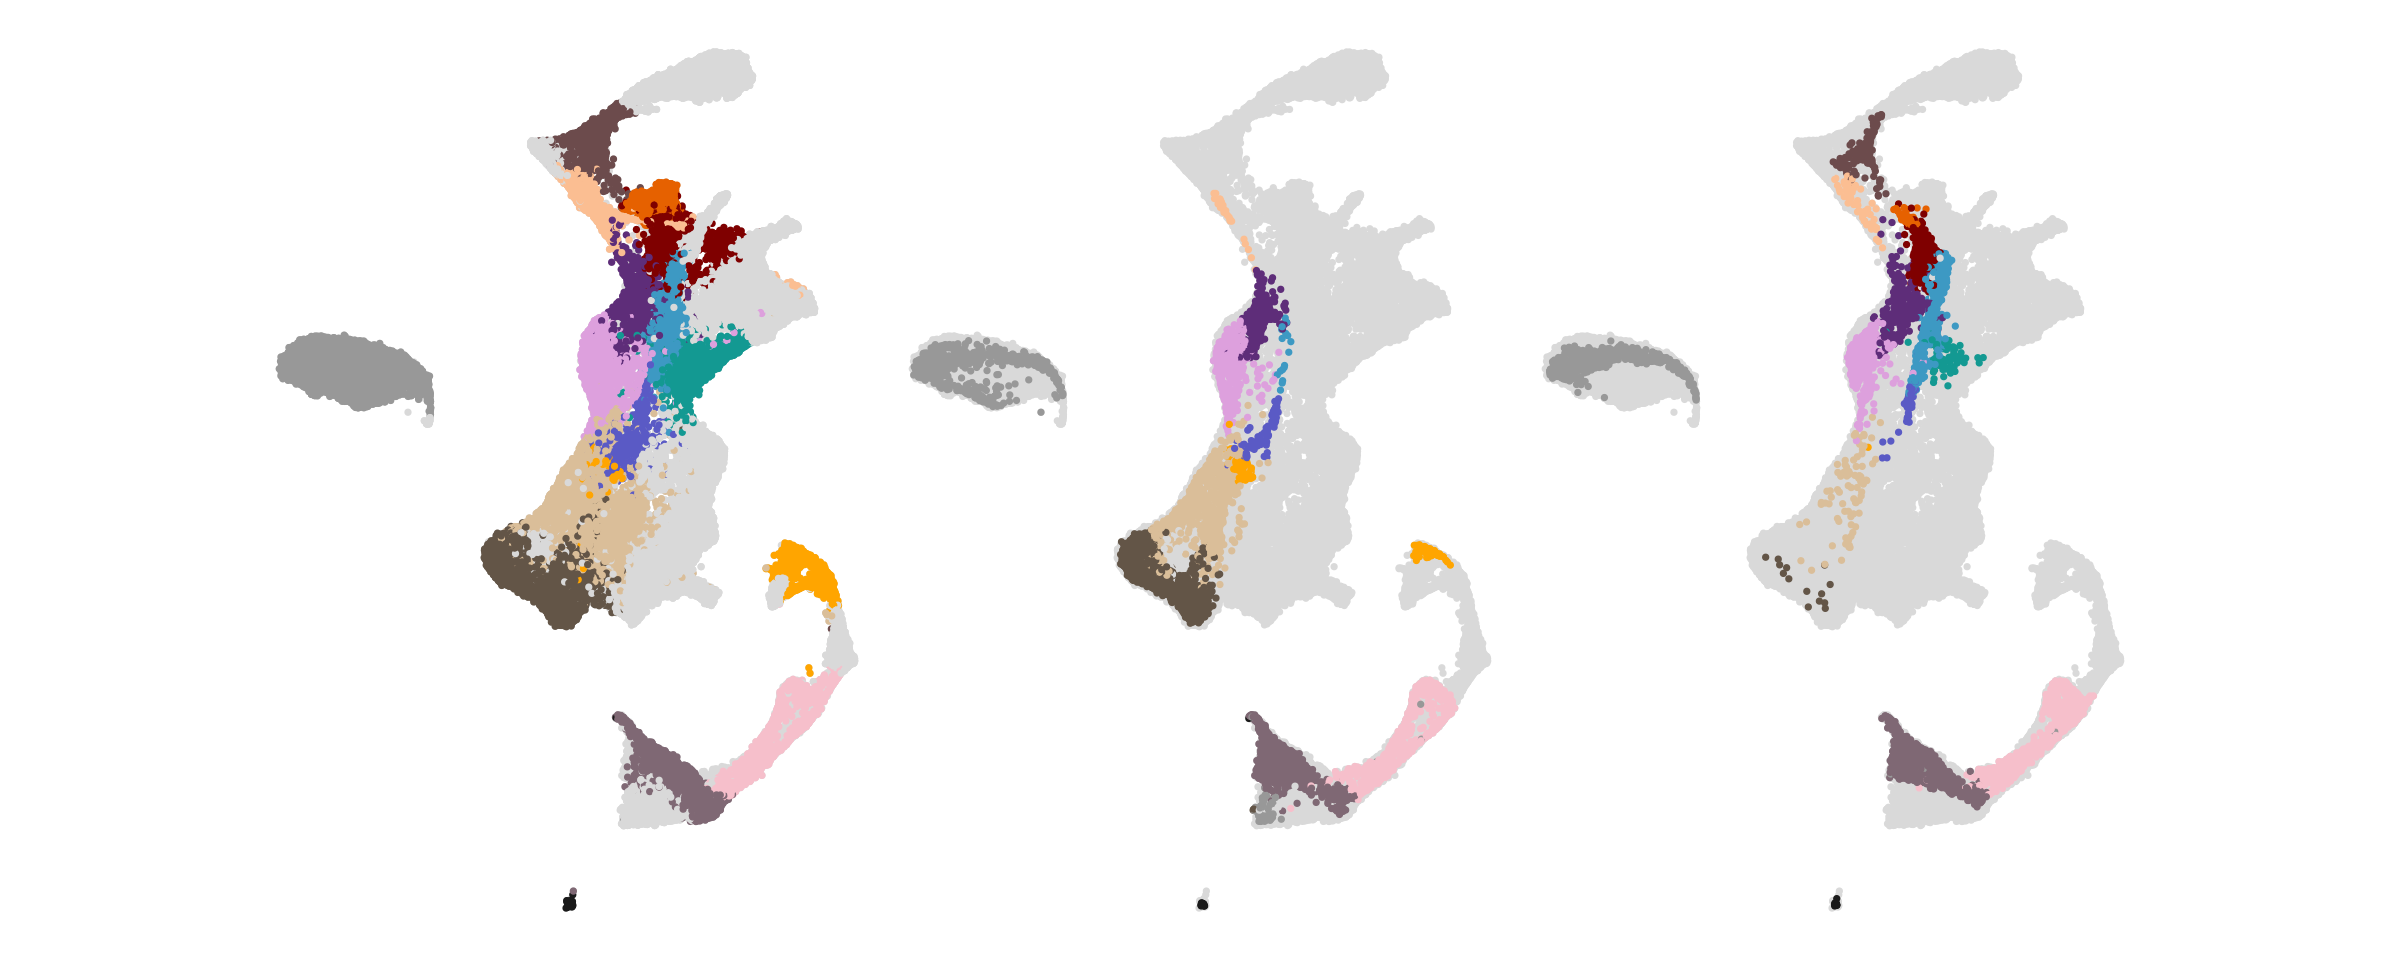

In [16]:
df_2 <- integrated_axin_metadata
point_size <- 1

# plot reference
df <- subset(integrated_axin_metadata, dataset %in% "Gastrulation Atlas")
p1 <- ggplot(data=df, aes(iUMAP_1, iUMAP_2, col=integrated_clusters_updated_ordered)) + 
  geom_point(data=df_2, aes(iUMAP_1, iUMAP_2), col='grey85', size = 1) + 
  geom_point(size = point_size) +
  scale_color_manual(values=Hernandez_colors) + 
  theme_void() + 
  theme(legend.position='none') + 
  coord_fixed()

# plot Axin Control 
df <- subset(integrated_axin_metadata, dataset %in% "Axin Control")
p2 <- ggplot(data=df, aes(iUMAP_1, iUMAP_2, col=integrated_clusters_updated_ordered)) + 
  geom_point(data=df_2, aes(iUMAP_1, iUMAP_2), col='grey85', size = 1) + 
  geom_point(size = point_size) +
  scale_color_manual(values=Hernandez_colors) + 
  theme_void() + 
  theme(legend.position='none') + 
  coord_fixed()

# plot Axin DKO
df <- subset(integrated_axin_metadata, dataset %in% "Axin DKO")
p3 <- ggplot(data=df, aes(iUMAP_1, iUMAP_2, col=integrated_clusters_updated_ordered)) + 
  geom_point(data=df_2, aes(iUMAP_1, iUMAP_2), col='grey85', size = 1) + 
  geom_point(size = point_size) +
  scale_color_manual(values=Hernandez_colors) + 
  theme_void() + 
  theme(legend.position='none') + 
  coord_fixed()
  
options(repr.plot.width=20, repr.plot.height=8) 
p1 | p2 | p3

In [17]:
# Save individual plots to PDF
ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2a_1.pdf", plot = p1, width = 6, height = 6, units = "in")
ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2a_2.pdf", plot = p2, width = 6, height = 6, units = "in")
ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2a_3.pdf", plot = p3, width = 6, height = 6, units = "in")

In [18]:
# Extract the legend from p1
legend_plot <- ggplot(data=df, aes(iUMAP_1, iUMAP_2, col=integrated_clusters_updated_ordered)) + 
  geom_point() +
  scale_color_manual(values=Hernandez_colors) + 
  theme_void() + 
  theme(legend.position='right')

legend_only <- get_legend(legend_plot)

# Convert to a plot object and save as PDF
legend_gg <- plot_grid(legend_only)
ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2a_legend.pdf", plot = legend_gg, width = 10, height = 10, units = "in")

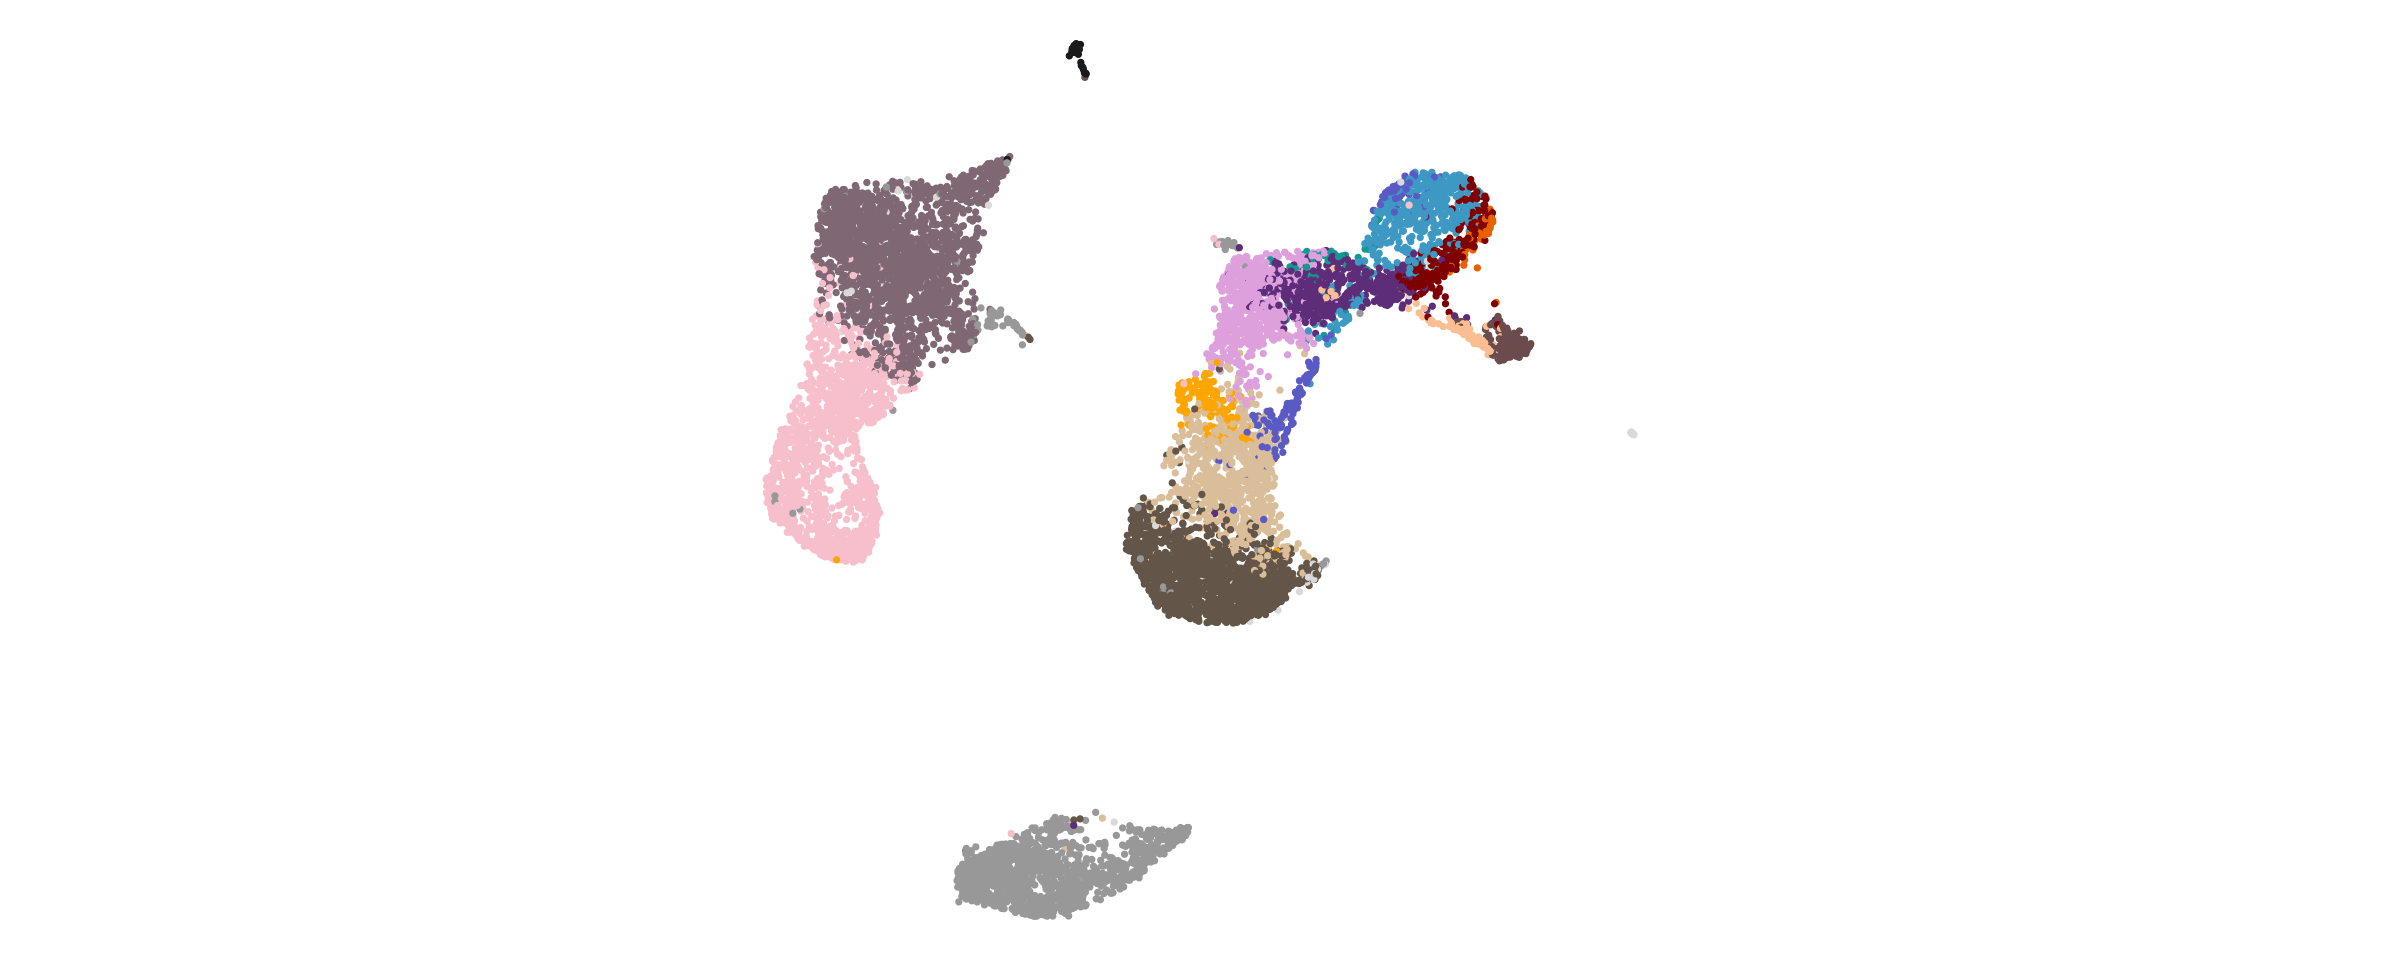

In [19]:
df_2 <- axin_metadata
point_size <- 1

# plot reference
df <- subset(axin_metadata, dataset %in% c("Axin Control", "Axin DKO"))
p1 <- ggplot(data=df, aes(UMAP_1, UMAP_2, col=integrated_clusters_updated_ordered)) + 
  #geom_point(data=df_2, aes(UMAP_1, UMAP_2), col='grey85', size = 1) + 
  geom_point(size = point_size) +
  scale_color_manual(values=Hernandez_colors) + 
  theme_void() + 
  theme(legend.position='none') + 
  coord_fixed()
  
options(repr.plot.width=20, repr.plot.height=8) 
p1

ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2b.pdf", plot = p1, width = 6, height = 6, units = "in")

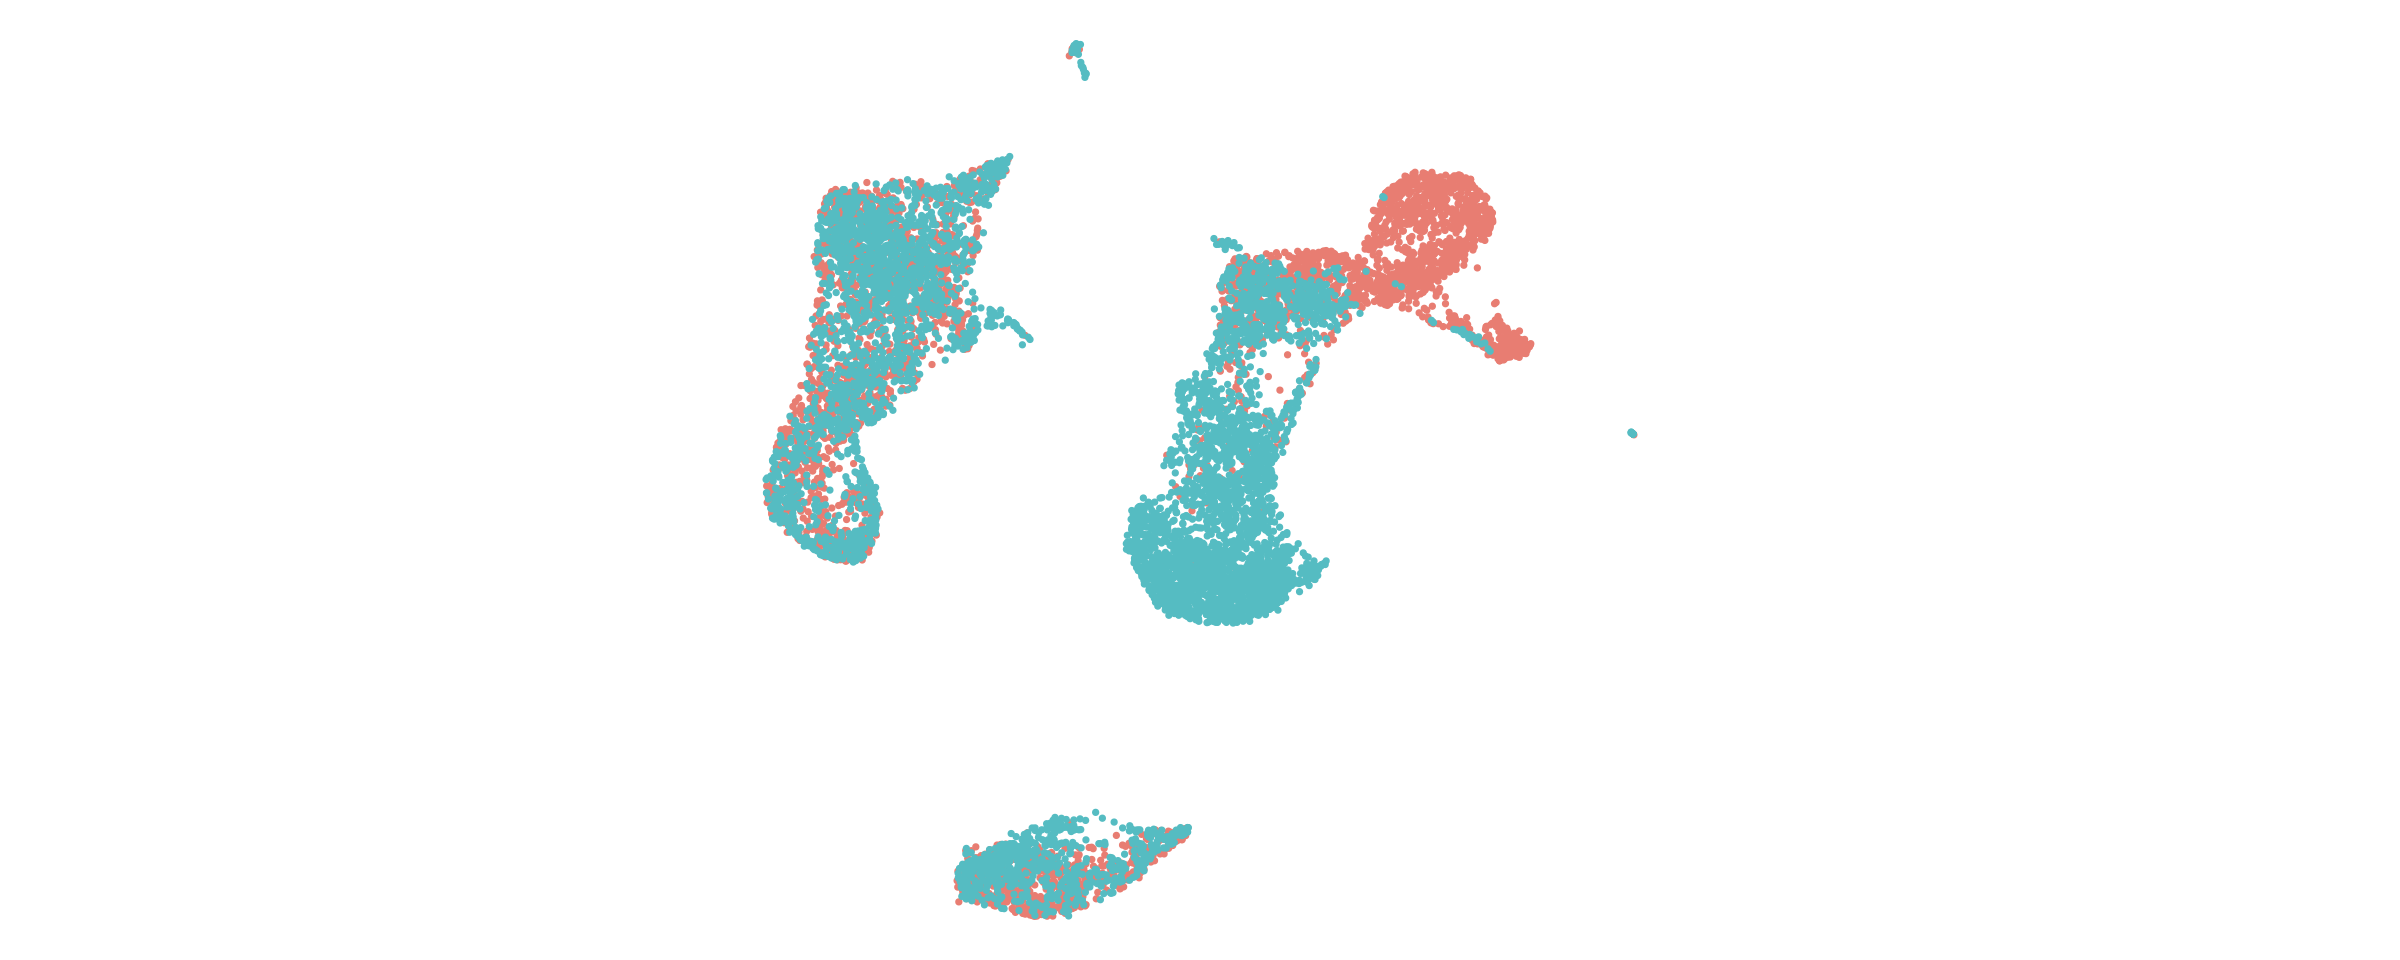

In [20]:
df_2 <- axin_metadata
point_size <- 1

# plot reference
df <- subset(axin_metadata, dataset %in% c("Axin Control", "Axin DKO"))
p1 <- ggplot(data=df, aes(UMAP_1, UMAP_2, col=dataset)) + 
  #geom_point(data=df_2, aes(UMAP_1, UMAP_2), col='grey85', size = 1) + 
  geom_point(size = point_size) +
  scale_color_manual(values=Hernandez_dataset_colors) + 
  theme_void() + 
  theme(legend.position='none') + 
  coord_fixed()
  
options(repr.plot.width=20, repr.plot.height=8) 
p1

ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2c.pdf", plot = p1, width = 6, height = 6, units = "in")

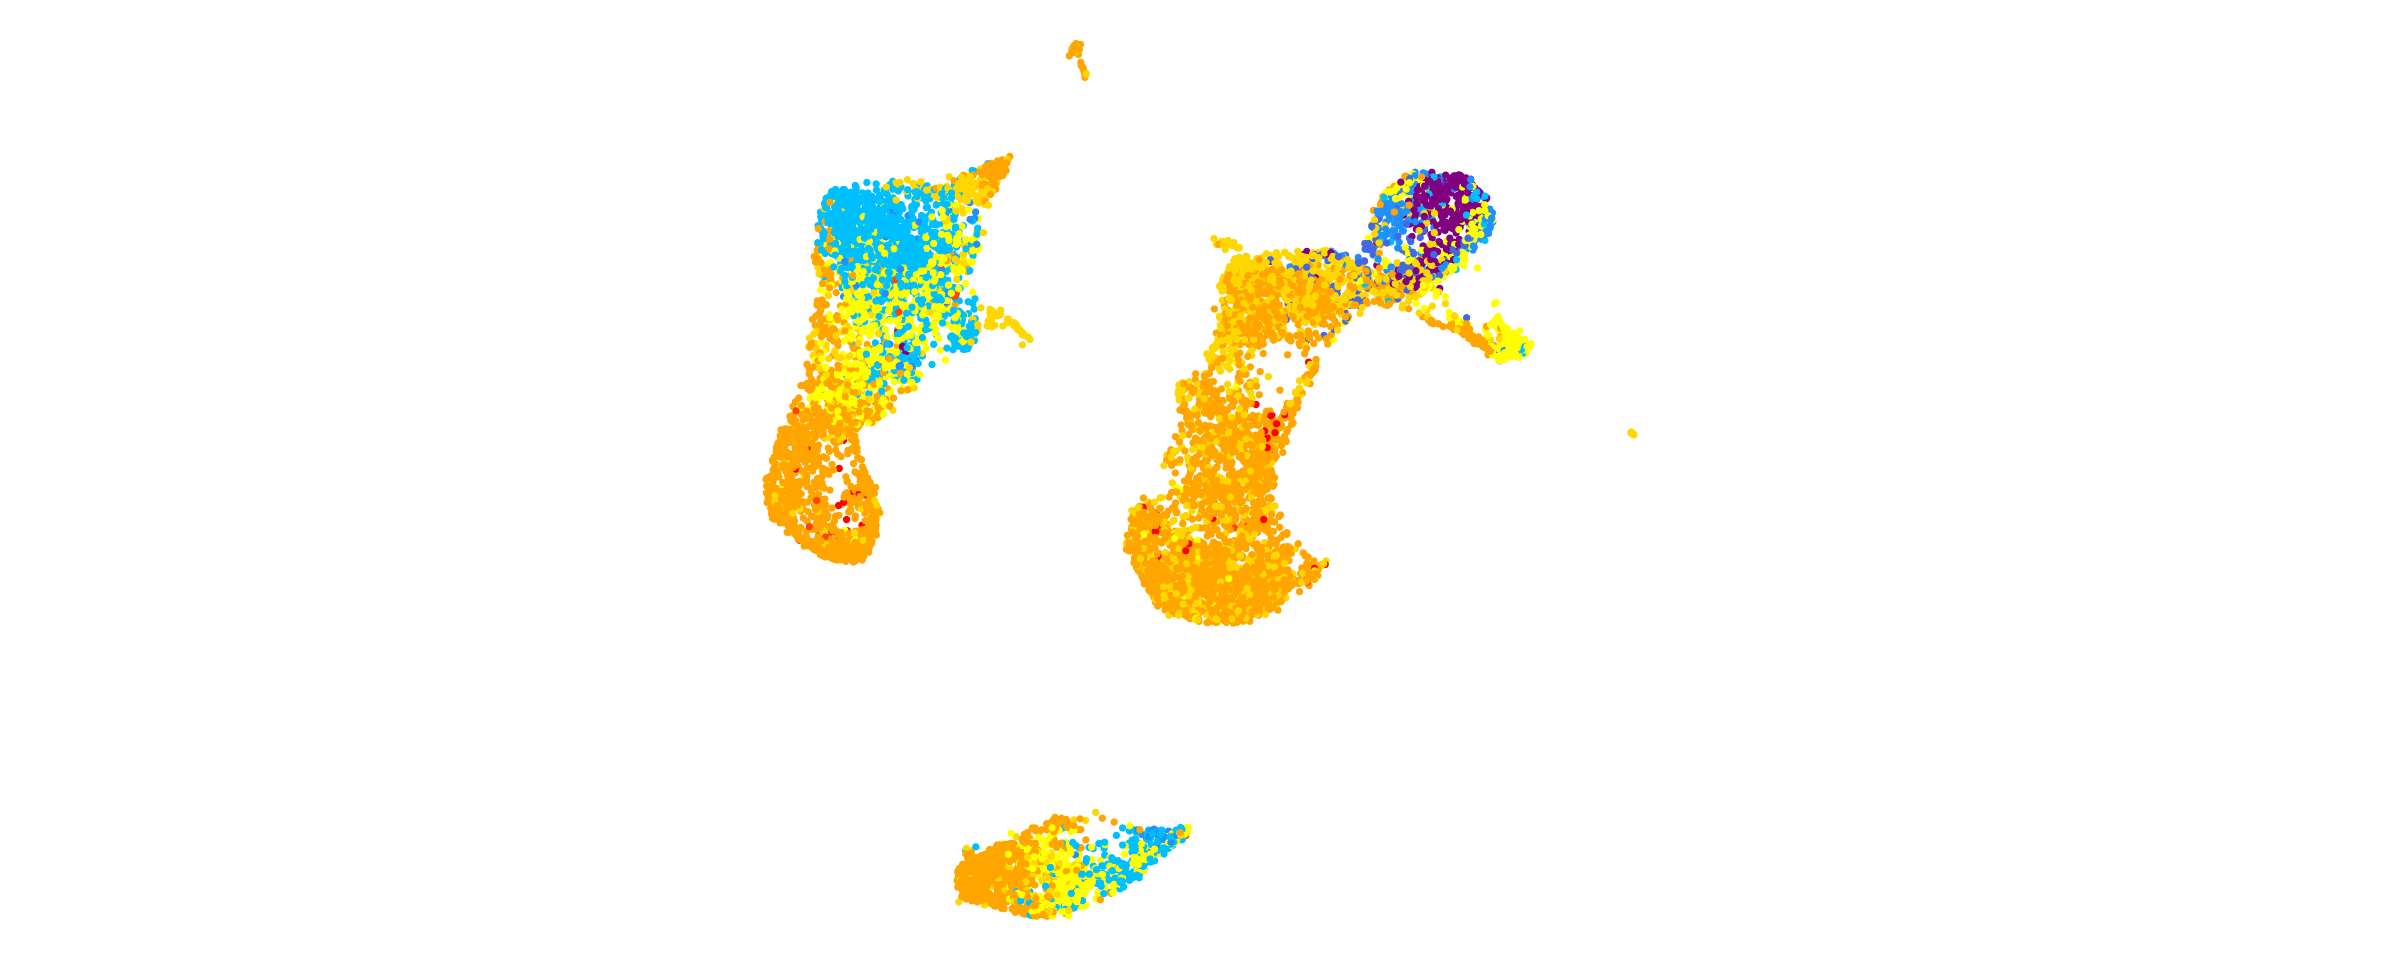

In [21]:
df_2 <- axin_metadata
point_size <- 1

# plot reference
df <- subset(axin_metadata, dataset %in% c("Axin Control", "Axin DKO"))
p1 <- ggplot(data=df, aes(UMAP_1, UMAP_2, col=stage_label)) + 
  #geom_point(data=df_2, aes(UMAP_1, UMAP_2), col='grey85', size = 1) + 
  geom_point(size = point_size) +
  scale_color_manual(values=Hernandez_stages_colors) + 
  theme_void() + 
  theme(legend.position='none') + 
  coord_fixed()
  
options(repr.plot.width=20, repr.plot.height=8) 
p1

ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2d.pdf", plot = p1, width = 6, height = 6, units = "in")

In [22]:
# Extract the legend from p1
legend_plot <- ggplot(data=df, aes(iUMAP_1, iUMAP_2, col=stage_label)) + 
  geom_point() +
  scale_color_manual(values=Hernandez_stages_colors) + 
  theme_void() + 
  theme(legend.position='right')

legend_only <- get_legend(legend_plot)

# Convert to a plot object and save as PDF
legend_gg <- plot_grid(legend_only)
ggsave("projects/10_Axin_1_2/github_submission/code/Dev_Cell_Revisions/github_submissions/outputs/fig2d_legend.pdf", plot = legend_gg, width = 10, height = 10, units = "in")

In [27]:
table(integrated_axin_metadata$dataset)


Gastrulation Atlas       Axin Control           Axin DKO 
             75559               5907               4343 

In [32]:
tail(celltype_by_genotype_cluster_ss)

,celltype,genotype,cluster,frequency,total_cells,proportions
,<fct>,<fct>,<fct>,<int>,<int>,<dbl>
4219,Ventral forebrain progenitors,Axin DKO,Intermediate Mesoderm,0,4343,0
4220,Ventral hindbrain progenitors,Axin DKO,Intermediate Mesoderm,0,4343,0
4221,Visceral endoderm,Axin DKO,Intermediate Mesoderm,0,4343,0
4222,YS endothelium,Axin DKO,Intermediate Mesoderm,0,4343,0
4223,YS mesothelium,Axin DKO,Intermediate Mesoderm,0,4343,0
4224,YS mesothelium-derived endothelial progenitors,Axin DKO,Intermediate Mesoderm,0,4343,0


## Generate the Bar Chart for Main Figure 2F

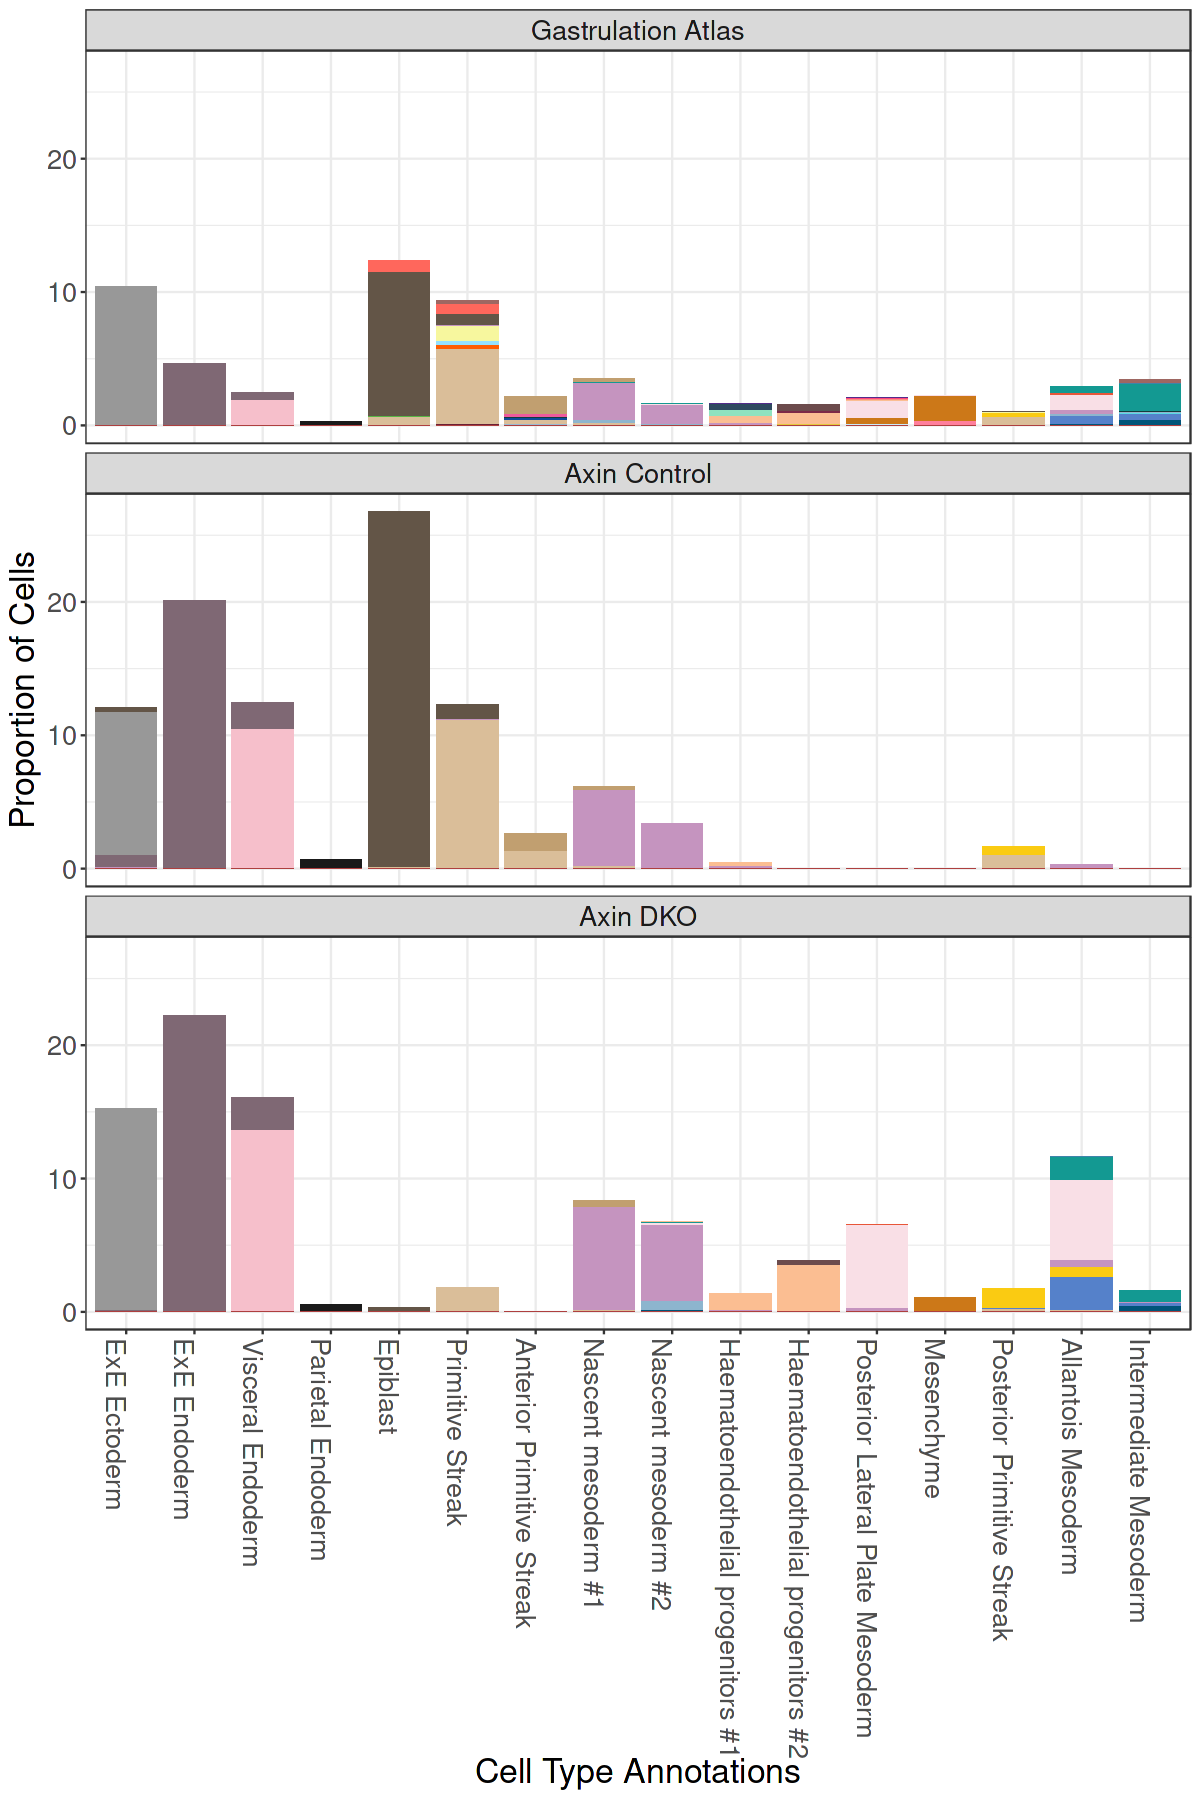

In [23]:
# Create a data frame tabulating the number of cells by celltype, dataset (genotype), and cluster
celltype_by_genotype_cluster <- as.data.frame(table(
  integrated_axin_metadata$extended_atlas_label,  # Cell type labels
  integrated_axin_metadata$dataset,               # Genotype info (e.g., "Axin Control", "Axin DKO")
  integrated_axin_metadata$integrated_clusters_updated_ordered  # Cluster identity
))

# Rename the columns for clarity
colnames(celltype_by_genotype_cluster) <- c("celltype", "genotype", "cluster", "frequency")

# Add a column for the total number of cells per genotype (summing over all clusters and cell types)
celltype_by_genotype_cluster <- celltype_by_genotype_cluster %>%
  group_by(genotype) %>%                             # Group by genotype
  mutate(total_cells = sum(frequency))               # Compute total cell count per genotype

# Compute proportions of each cell type within each genotype
celltype_by_genotype_cluster <- celltype_by_genotype_cluster %>%
  mutate(proportions = (frequency / total_cells) * 100)  # Proportion in percentage

# Convert back to plain data frame (ungrouped)
celltype_by_genotype_cluster <- as.data.frame(celltype_by_genotype_cluster)

# Filter out low-quality clusters to clean up the visualization
celltype_by_genotype_cluster_ss <- filter(celltype_by_genotype_cluster, !cluster %in% "Low Quality")

# Optional: Reorder genotype levels manually (commented out here)
# celltype_by_genotype_cluster$data <- factor(celltype_by_genotype_cluster$genotype, levels = c("wildtype", "mutant"))

# Set up plot dimensions for Jupyter notebook or inline plotting
options(repr.plot.width = 10, repr.plot.height = 15)

# Generate a stacked bar plot:
ggplot(celltype_by_genotype_cluster_ss, aes(x = cluster, y = proportions, fill = celltype)) +
  geom_bar(stat = "identity") +                             # Use raw proportion values to control bar height
  scale_fill_manual(values = Imaz_Rosshandler_colors) +     # Use custom color palette for cell types
  facet_wrap(~genotype, dir = "v") +                        # Create separate vertical panels for each genotype
  theme_bw() +                                               # Use a clean black-and-white theme
  theme(
    legend.position = 'none',                                # Hide legend
    text = element_text(size = 20),                          # Increase font size
    axis.text.x = element_text(angle = -90, vjust = 1, hjust = 0)  # Rotate x-axis labels vertically
  ) +
  labs(
    x = "Cell Type Annotations",
    y = "Proportion of Cells",
    fill = "Gastrulation Atlas Cell Type"                   # Label for fill variable (not shown since legend is off)
  )

In [33]:
loadedNamespaces()

[1] "utf8"                   "reticulate"             "tidyselect"            
  [4] "RSQLite"                "AnnotationDbi"          "htmlwidgets"           
  [7] "grid"                   "BiocParallel"           "Rtsne"                 
 [10] "munsell"                "ScaledMatrix"           "ragg"                  
 [13] "codetools"              "ica"                    "StabMap"               
 [16] "statmod"                "scran"                  "pbdZMQ"                
 [19] "future"                 "miniUI"                 "withr"                 
 [22] "spatstat.random"        "colorspace"             "progressr"             
 [25] "Biobase"                "filelock"               "uuid"                  
 [28] "Seurat"                 "stats4"                 "SingleCellExperiment"  
 [31] "ROCR"                   "tensor"                 "listenv"               
 [34] "labeling"               "MatrixGenerics"         "repr"                  
 [37] "GenomeInfoDbData"       "harmony"                "polyclip"              
 [40] "stats"                  "farver"                 "bit64"                 
 [43] "parallelly"             "vctrs"                  "generics"              
 [46] "BiocFileCache"          "R6"                     "GenomeInfoDb"          
 [49] "ggbeeswarm"             "rsvd"                   "locfit"                
 [52] "bitops"                 "spatstat.utils"         "cachem"                
 [55] "DelayedArray"           "promises"               "scales"                
 [58] "rgeos"                  "beeswarm"               "gtable"                
 [61] "beachmat"               "Cairo"                  "globals"               
 [64] "goftest"                "rlang"                  "utils"                 
 [67] "methods"                "systemfonts"            "splines"               
 [70] "lazyeval"               "spatstat.geom"          "BiocManager"           
 [73] "yaml"                   "reshape2"               "abind"                 
 [76] "httpuv"                 "base"                   "tools"                 
 [79] "ggplot2"                "ellipsis"               "spatstat.core"         
 [82] "RColorBrewer"           "BiocGenerics"           "ggridges"              
 [85] "Rcpp"                   "plyr"                   "base64enc"             
 [88] "sparseMatrixStats"      "zlibbioc"               "purrr"                 
 [91] "RCurl"                  "rpart"                  "deldir"                
 [94] "pbapply"                "viridis"                "cowplot"               
 [97] "S4Vectors"              "zoo"                    "SeuratObject"          
[100] "SummarizedExperiment"   "ggrepel"                "cluster"               
[103] "magrittr"               "data.table"             "scattermore"           
[106] "lmtest"                 "RANN"                   "fitdistrplus"          
[109] "matrixStats"            "patchwork"              "mime"                  
[112] "evaluate"               "xtable"                 "IRanges"               
[115] "gridExtra"              "compiler"               "scater"                
[118] "tibble"                 "KernSmooth"             "crayon"                
[121] "htmltools"              "mgcv"                   "later"                 
[124] "tidyr"                  "DBI"                    "ExperimentHub"         
[127] "dbplyr"                 "MASS"                   "rappdirs"              
[130] "Matrix"                 "cli"                    "datasets"              
[133] "grDevices"              "parallel"               "metapod"               
[136] "igraph"                 "GenomicRanges"          "pkgconfig"             
[139] "sp"                     "IRdisplay"              "plotly"                
[142] "scuttle"                "spatstat.sparse"        "vipor"                 
[145] "dqrng"                  "XVector"                "graphics"              
[148] "stringr"                "d

In [34]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.1.1               stringr_1.5.0              
 [3] Matrix_1.5-1                plotly_4.10.0              
 [5] sp_1.5-0                    SeuratObject_4.1.2         
 [7] Seurat_4.2.0                patchwork_1.1.2            
 [9] harmony_0.1.0               Rcpp_1.0.10                
[11] scran_1.26.2            